# Team Comparision Notebook
### Adapting code from previous season FF_Viz_Workbook
- will be used to create plots that compare teams
    - Head to head
    - Groups of 4 (will be useful for tourneys)
    - Entire Conference - likely just the scatter plots


### Setup
- Dependencies
- File Paths
- Theme Settings - Font, BG, ect

##### Dependencies

In [502]:
# Dependencies

# Basics
import os
import sys
import time
import sqlite3

# Data manipulation
import numpy as np
import pandas as pd
from scipy.ndimage import rotate

# Matplot lib and seaborn with sublibraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.legend_handler import HandlerTuple
from matplotlib.legend_handler import HandlerBase
from matplotlib import font_manager

from PIL import Image



##### File Paths

In [503]:
## Load The Exo 2 font in case of problems with the font
font_path = 'C:/Windows/Fonts/Exo 2.tff'
locations =['../data/Exo_2'] # Font Location

font_files = font_manager.findSystemFonts(fontpaths=locations)

for file in font_files:
    font_manager.fontManager.addfont(file)


In [504]:
## File Paths
data_folder = os.path.join('..', 'data/') # Data Folder Path
temp_folder = os.path.join('..', 'TEMP/',) # Temp Folder Path
TEMP_FOLDER = temp_folder # Temp Folder Path as used in legacy code
db_path = os.path.join(data_folder, 'db', '2024_Dec_02_CLEAN.db') # Database Path
image_folder = os.path.join('..', 'images/') # Image Folder Path
logo_folder = os.path.join(image_folder, 'logos/') # Logo Folder Path
conference_logo_folder = os.path.join(logo_folder, 'conference') # Conference Logo Folder Path
export_folder = os.path.join(image_folder, 'export/') # Export Folder Path
background_folder = os.path.join(image_folder, 'background/') # Background Folder Path

# Other paths
school_info_path = os.path.join(data_folder, 'arena_school_info.csv') # School Info Path


## Other Variables that are so far unavailable
# pairwise_path = os.path.join(data_folder, 'pairwise') # Current Pairwise Folder Path
# pairwise_df = pd.read_csv(os.path.join(pairwise_path)

##### Start Loading data

In [505]:
## Load the database
conn = sqlite3.connect(db_path)

# load the master roster table from the database
main_roster_df = pd.read_sql_query("SELECT * FROM master_roster", conn)
# main_roster_df.head() # Check the data

### Team Color and Logo Info - Library

In [506]:
## Load the school info to get hex codes, logo files, and other info
school_info_df = pd.read_csv(school_info_path)


# Remove punctuation from the school names (dashes with spaces, . and ' with nothing)
school_info_df['Team'] = school_info_df['Team'].str.replace('-', ' ')
school_info_df['Team'] = school_info_df['Team'].str.replace('.', '')
school_info_df['Team'] = school_info_df['Team'].str.replace("'", '')
# school_info_df.head() # Check the data

# # Create a color dictionary with just the primary (hex1) and secondary (hex2) colors from the school info
# Team: hex1, hex2
# Drop unused columns
school_color_df = school_info_df[['Team', 'hex1', 'hex2']]
color_mapping = school_color_df.set_index('Team').T.to_dict('list')
# color_mapping # Show dictionary
## MAY NEED TO ADD LEADING/ TRAILING zeros to the hex codes

# Create a dictionary of school logos
# Team: logo + '.png'
# Drop unused columns
school_logo_df = school_info_df[['Team', 'logo_abv']]
school_logo_df['logo_abv'] = school_logo_df['logo_abv'] + '.png'
logo_mapping = school_logo_df.set_index('Team')['logo_abv'].to_dict()
# logo_mapping # Check the dictionary




C:\Users\jbanc\AppData\Local\Temp\ipykernel_4932\2724386260.py:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  color_mapping = school_color_df.set_index('Team').T.to_dict('list')
C:\Users\jbanc\AppData\Local\Temp\ipykernel_4932\2724386260.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_logo_df['logo_abv'] = school_logo_df['logo_abv'] + '.png'


#### Logo Image Helper Functions
- Add logos to plot
- Check logo sizes and Transparency

In [507]:
## NEW SUB FUNCTION 3/24/24
def add_logos_to_plot(data_df, x_col, y_col, logo_mapping, logo_folder, ax, teams_in_region):
    # Plot logos for specific teams
    for team in teams_in_region:
        team_data = data_df[data_df['Team'] == team]
        if not team_data.empty:
            x = team_data[x_col].values[0]
            y = team_data[y_col].values[0]
            logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
            if logo_path:
                try:
                    logo_img = plt.imread(logo_path)
                    imagebox = OffsetImage(logo_img, zoom=0.15)  # Adjust zoom as needed
                    ab = AnnotationBbox(imagebox, (x, y), frameon=False, xybox=(10, 20), boxcoords="offset points", pad=0)
                    ax.add_artist(ab)  # Apply the ax here as the artist is being added to ax
                except Exception as e:
                    print(f"Error adding logo for {team}: {e}")




##### Helper Functions to Check logo formats and color dictionary format

In [508]:
def clean_color_mapping(color_mapping):
    """
    Cleans and validates color codes in the color_mapping dictionary.
    Ensures all colors are valid hex codes starting with '#'.

    Parameters:
    - color_mapping (dict): A dictionary where the key is the team name and the value is a list of hex colors.

    Returns:
    - cleaned_mapping (dict): A dictionary with properly formatted hex color codes.
    """
    cleaned_mapping = {}
    for team, colors in color_mapping.items():
        cleaned_colors = []
        for color in colors:
            if isinstance(color, str):
                # Ensure it starts with '#' and is a valid hex color code
                color = color.strip()
                if not color.startswith('#'):
                    color = f'#{color}'
                if len(color) == 7 and all(c in '0123456789ABCDEFabcdef' for c in color[1:]):
                    cleaned_colors.append(color)
                else:
                    # Use a fallback color if invalid
                    cleaned_colors.append('#000000')  # Default to black for invalid colors
            else:
                cleaned_colors.append('#000000')  # Default to black for non-string values
        cleaned_mapping[team] = cleaned_colors
    return cleaned_mapping

# Clean and validate the color mapping
color_mapping = clean_color_mapping(color_mapping)

# Now the color_mapping dictionary has valid hex color codes



In [509]:
def convert_to_rgba(logo_mapping, logo_folder):
    for team, filename in logo_mapping.items():
        file_path = os.path.join(logo_folder, filename)
        try:
            with Image.open(file_path) as img:
                # Convert the image to RGBA if not already in that mode
                if img.mode != 'RGBA':
                    rgba_image = img.convert('RGBA')
                    # Save the converted image back to the folder
                    rgba_image.save(file_path)
                    print(f"Converted {filename} to RGBA.")
                else:
                    print(f"{filename} is already RGBA.")
        except FileNotFoundError:
            print(f"File {filename} not found in {logo_folder}.")
        except Exception as e:
            print(f"An error occurred with {filename}: {e}")

# Run the conversion function
convert_to_rgba(logo_mapping, logo_folder)

# Function to check if images have an alpha channel
def check_image_channels(logo_mapping, logo_folder):
    results = {}
    for team, filename in logo_mapping.items():
        try:
            file_path = os.path.join(logo_folder, filename)
            with Image.open(file_path) as img:
                # Check if the image has an alpha channel
                results[team] = "Alpha channel present" if img.mode == 'RGBA' else "No alpha channel"
        except FileNotFoundError:
            results[team] = "File not found"
        except Exception as e:
            results[team] = str(e)
    return results

# Run the check and print the results
alpha_check_results = check_image_channels(logo_mapping, logo_folder)
# alpha_check_results

afa.png is already RGBA.
akf.png is already RGBA.
aka.png is already RGBA.
aic.png is already RGBA.
asu.png is already RGBA.
arm.png is already RGBA.
bmj.png is already RGBA.
ben.png is already RGBA.
bc_.png is already RGBA.
bu_.png is already RGBA.
bgs.png is already RGBA.
brn.png is already RGBA.
cns.png is already RGBA.
clk.png is already RGBA.
clg.png is already RGBA.
cc_.png is already RGBA.
_con.png is already RGBA.
cor.png is already RGBA.
dar.png is already RGBA.
den.png is already RGBA.
fsu.png is already RGBA.
har.png is already RGBA.
hcr.png is already RGBA.
lss.png is already RGBA.
liu.png is already RGBA.
uml.png is already RGBA.
uma.png is already RGBA.
mrc.png is already RGBA.
mer.png is already RGBA.
mia.png is already RGBA.
mic.png is already RGBA.
msu.png is already RGBA.
mtu.png is already RGBA.
min.png is already RGBA.
mns.png is already RGBA.
mnd.png is already RGBA.
unh.png is already RGBA.
nia.png is already RGBA.
ndk.png is already RGBA.
noe.png is already RGBA.

### Figure Size and Font Settings

In [510]:
# figure_size = square_fig

#### INSTAGRAM SIZE - Portrait
dpi = 600
width, height = 1080, 1350  # in pixels
# figure_size = (width / dpi, height / dpi)  # in inches
figure_size = (10,10)

font = "Exo 2"
size1 = 24
size2 = 20
size3 = 16
large_tick_label_size = 20
# Set up Font Parameters that are used in some of the legacy code
## FONT PARAMETERS

font_title_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size1}
font_label_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size2}
font_tick_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size3}
font_label_large_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': large_tick_label_size}
font_tick_large_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': large_tick_label_size}
font_tag_parm = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size1}
font_tag_parm_2 = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size1}


## Set the column widths for the table in the scatter plots
col_widths = [0.30, 0.225, 0.225]  # Adjust the values as needed

### Roster Load and Manipulation

In [511]:
# Load Roster
roster_df = main_roster_df

roster_df = roster_df.rename(columns={'Current Team': 'Team'}) # Rename column Current Team to Team
# Calculate average age for each team
roster_df['DOB'] = pd.to_datetime(roster_df['DOB'])
# Calulate each players age in days
roster_df['Age'] = (pd.Timestamp.now() - roster_df['DOB']).dt.days

# Group by Team and calculate the average age for each
team_age_df = roster_df.groupby('Team')['Age'].mean().reset_index()
# Conver to years
team_age_df['Age'] = team_age_df['Age'] / 365

# roster_df.head()
# team_age_df.head()

### Conference Member Dictionary

In [512]:
# Define the conferences
conference_teams_mens = {
    'Atlantic': ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
                 'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart'],
    'Big Ten': ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin'],
    'CCHA': ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
             'Minnesota State', 'Northern Michigan', 'St Thomas'],
    'ECAC': ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
             'Rensselaer', 'St Lawrence', 'Union', 'Yale'],
    'Hockey East': ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                    'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont'],
    'NCHC': ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 
             'St Cloud State', 'Western Michigan'],
    'Independents': ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']
}

# Load conference logos - Mens
conference_logo_mapping_mens = {
    'Atlantic': 'atlantic.png',
    'Big Ten': 'big_ten.png',
    'CCHA': 'ccha.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NCHC': 'nchc.png',
    'Independents': 'independent_scaled.png'
}

### Conference Membersip - Women's D1
w_atlantic = ['Lindenwood', 'Mercyhurst', 'Penn State', 
            'RIT', 'Robert Morris', 'Syracuse']
w_ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']
w_hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Holy Cross', 
                'Maine', 'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']
w_newha = ['Assumption', 'Franklin Pierce', 'Long Island', 'Post', 'Sacred Heart',
        'Saint Anselm', 'Saint Michaels', 'Stonehill']
w_wcha = ['Bemidji State', 'Minnesota', 'Minnesota Duluth', 'Minnesota State', 'Ohio State', 
            'St Cloud State', 'St Thomas', 'Wisconsin']

conference_teams_womens = {
    'Atlantic': w_atlantic,
    'ECAC': w_ecac,
    'Hockey East': w_hockey_east,
    'NewHA': w_newha,
    'WCHA': w_wcha
}
conference_logo_mapping_womens = {
    'Atlantic': 'atlantic.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NewHA': 'w_newha.png',
    'WCHA': 'w_wcha.png'
}

## Start Plotting

#### Define Teams to include in Plots

In [513]:
# Groups Defined Above to Call
# conference_teams_mens
# 'Atlantic', 'Big Ten', 'CCHA', 'ECAC', 'Hockey East', 'NCHC', 'Independents'

# conference_teams_womens
# 'Atlantic', 'ECAC', 'Hockey East', 'NewHA', 'WCHA'

plot_group = 'Big Ten'  # Set the group to plot

# Teams to plot
# Get list from conference dictionary
teams_to_plot = conference_teams_mens[f'{plot_group}'] # Set the group to plot from the Mens Conference Teams
# teams_to_plot = conference_teams_womens[f'{plot_group}'] # Set the group to plot from the Womens Conference Teams

# Title of Group
group_title = f'{plot_group}'

#### Set Background Image
path_to_bg_image =  'main1.png' #
alpha_value = 0.1 # Set the transparency of the background image
# Load the background image
bg_img = mpimg.imread(background_folder + path_to_bg_image)



#### Shots Per Game

In [514]:
def create_avg_shots_plot(group_title, conn, logo_mapping, logo_folder, teams_to_plot):
    figure_size = (10, 10)  # Optimal size for platforms like Instagram

    avg_shots_query = """
    WITH UniqueGames AS (
        SELECT DISTINCT * FROM linescore
    )
    SELECT
        a.Team,
        AVG(a.shotsT) AS Avg_Shots_Taken,
        AVG(b.shotsT) AS Avg_Shots_Allowed
    FROM UniqueGames AS a
    JOIN UniqueGames AS b ON a.Game_ID = b.Game_ID AND a.Team != b.Team
    GROUP BY a.Team;

    """
    
    # Execute the query to fetch data for all teams
    avg_shots_df = pd.read_sql(avg_shots_query, conn)

    # Calculate average and standard deviation for "Shots Taken" and "Shots Allowed"
    avg_shots_taken = avg_shots_df['Avg_Shots_Taken'].mean()
    std_shots_taken = avg_shots_df['Avg_Shots_Taken'].std()
    avg_shots_allowed = avg_shots_df['Avg_Shots_Allowed'].mean()
    std_shots_allowed = avg_shots_df['Avg_Shots_Allowed'].std()

    # Create the scatter plot for all teams
    fig, ax = plt.subplots(figsize=figure_size)
    sns.scatterplot(data=avg_shots_df, x='Avg_Shots_Allowed', y='Avg_Shots_Taken', color='darkgrey', ax=ax)

    # Add trend line
    sns.regplot(data=avg_shots_df, x='Avg_Shots_Allowed', y='Avg_Shots_Taken', scatter=False, color='blue')

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Subtract 2 from the x-minimum for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and Adjust y-limits if needed
    ymin, ymax = ax.get_ylim()

    # Now, plot the average lines and standard deviation markers after setting the axis limits
    plt.axhline(y=avg_shots_taken, color='red', linestyle='--', linewidth=0.8)
    plt.axvline(x=avg_shots_allowed, color='red', linestyle='--', linewidth=0.8)
    plt.errorbar(avg_shots_allowed, avg_shots_taken, xerr=std_shots_allowed, 
                 yerr=std_shots_taken, color='purple', fmt='o')

    # Set the background image
    # Ensure that the extent of the background image is also adjusted to the new xmin
    plt.imshow(bg_img, aspect='auto', extent=[new_xmin, xmax, ymin, ymax], zorder=0, alpha=alpha_value)

    # Overlay logos for specific teams in the region
    teams_in_region = teams_to_plot
    add_logos_to_plot(avg_shots_df, 'Avg_Shots_Allowed', 'Avg_Shots_Taken', logo_mapping, logo_folder, ax, teams_in_region)

    # Create table data
    table_data = [['Team', 'Avg Shots', 'Avg Allowed']]
    for team in teams_in_region:
        team_data = avg_shots_df[avg_shots_df['Team'] == team]
        if not team_data.empty:
            table_data.append([
                team, 
                f"{team_data['Avg_Shots_Taken'].values[0]:.2f}",
                f"{team_data['Avg_Shots_Allowed'].values[0]:.2f}"
            ])

    # Define the column widths, making the first column wider
    # col_widths = [0.25, 0.225, 0.225]  # Adjust the values as needed

    # Add a table at the top right of the plot & Set Parameters
    table = plt.table(cellText=table_data, loc='best', 
                      colWidths=col_widths,
                      cellLoc='center', 
                      bbox=[0.45, 0, 0.5, 0.3]
                      )
    
    # Customize the table properties
    table.auto_set_font_size(False)
    table.set_fontsize(12)  # Set the fontsize
    table.scale(1, 1.5)  # Scale the table for width and height

    # Set individual cell properties
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            # Header row
            cell.set_text_props(weight='bold')  # Make the header bold
            cell.set_facecolor('lightgrey')  # Header background color
        else:
            # All other rows
            cell.set_facecolor('none')  # Make cells transparent
            # cell.set_text_props(weight='bold')  # Optionally make text bold
        cell.set_edgecolor('w')  # Set the border color to white

    # Add title and axis labels
    plt.title(f'Shots Per Game: {group_title}', fontdict=font_title_param)
    plt.xlabel('Average Shots Allowed', fontdict=font_label_param)
    plt.ylabel('Average Shots Taken', fontdict=font_label_param)
    # Set the tick labels font size and properties
    plt.xticks(fontsize=large_tick_label_size)
    plt.yticks(fontsize=large_tick_label_size)


    # Save plot to TEMP_FOLDER
    plot_path = f'{TEMP_FOLDER}{group_title}_shots_plot.png'
    plt.savefig(plot_path, bbox_inches='tight')


    plt.show()


#### Call the Shots Plot

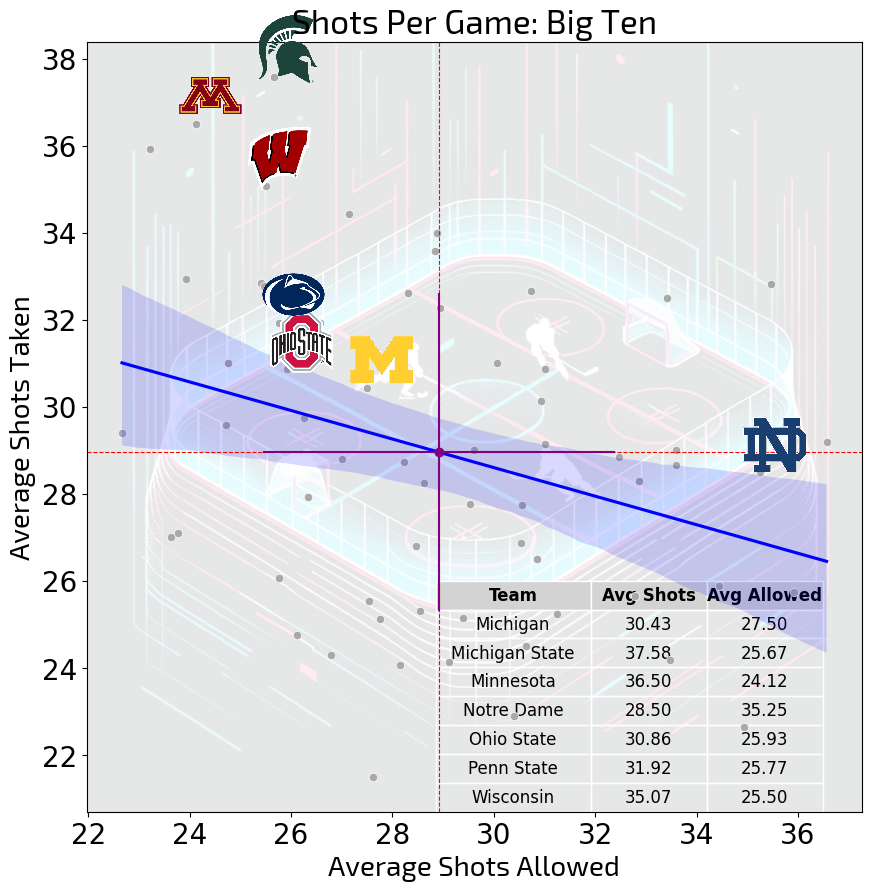

In [515]:
## Call the function
create_avg_shots_plot(group_title, conn, logo_mapping, logo_folder, teams_to_plot)

#### Average Goals Per Game

In [516]:
def create_avg_goals_plot(region_name, teams_to_plot):
    figure_size = (10, 10)  # Optimal size for platforms like Instagram
    
    # SQL query to calculate average goals
    avg_goals_query = """
    WITH UniqueGames AS (
        SELECT DISTINCT * FROM linescore
    )
    SELECT 
        UG1.Team, 
        SUM(UG1.goalsT) AS Total_Goals_Scored, 
        SUM(UG2.goalsT) AS Total_Goals_Allowed,
        COUNT(DISTINCT UG1.Game_ID) AS Games_Played
    FROM 
        UniqueGames UG1
    JOIN 
        UniqueGames UG2 ON UG1.Game_ID = UG2.Game_ID AND UG1.Team != UG2.Team
    GROUP BY 
        UG1.Team;
    """
    
    # Execute the query and store the results in a DataFrame
    avg_goals_df = pd.read_sql(avg_goals_query, conn)

    # Calculate averages of goals scored and allowed
    avg_goals_df['Avg_Goals_Scored'] = avg_goals_df['Total_Goals_Scored'] / avg_goals_df['Games_Played']
    avg_goals_df['Avg_Goals_Allowed'] = avg_goals_df['Total_Goals_Allowed'] / avg_goals_df['Games_Played']

    # Calculate averages and standard deviations
    avg_goals_scored = avg_goals_df['Avg_Goals_Scored'].mean()
    std_goals_scored = avg_goals_df['Avg_Goals_Scored'].std()
    avg_goals_allowed = avg_goals_df['Avg_Goals_Allowed'].mean()
    std_goals_allowed = avg_goals_df['Avg_Goals_Allowed'].std()

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=figure_size)
    sns.scatterplot(data=avg_goals_df, x='Avg_Goals_Allowed', y='Avg_Goals_Scored', color='darkgrey', ax=ax)

    # Add trend line
    sns.regplot(data=avg_goals_df, x='Avg_Goals_Allowed', y='Avg_Goals_Scored', scatter=False, color='blue')

    # Adjust axes
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    new_ymax = ymax + 0.25
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, new_ymax)

    # Add average lines and standard deviation markers
    plt.axhline(y=avg_goals_scored, color='red', linestyle='--', linewidth=0.8)
    plt.axvline(x=avg_goals_allowed, color='red', linestyle='--', linewidth=0.8)
    plt.errorbar(avg_goals_allowed, avg_goals_scored, xerr=std_goals_allowed, 
                 yerr=std_goals_scored, color='purple', fmt='o')

    # Set the background image
    plt.imshow(bg_img, aspect='auto', extent=[xmin, xmax, ymin, new_ymax], zorder=0, alpha=alpha_value)

    # Overlay logos for the teams in the region
    teams_in_region = teams_to_plot  # Use the teams passed as an argument
    add_logos_to_plot(avg_goals_df, 'Avg_Goals_Allowed', 'Avg_Goals_Scored', logo_mapping, logo_folder, ax, teams_in_region)

    # Create table data
    table_data = [['Team', 'Goals For', 'Goals Against']]
    for team in teams_in_region:
        team_data = avg_goals_df[avg_goals_df['Team'] == team]
        if not team_data.empty:
            table_data.append([
                team, 
                f"{team_data['Avg_Goals_Scored'].values[0]:.2f}",
                f"{team_data['Avg_Goals_Allowed'].values[0]:.2f}"
            ])

    # Define the column widths
    col_widths = [0.30, 0.225, 0.225]

    # Add a table at the top right of the plot
    table = plt.table(cellText=table_data, loc='best', 
                      colWidths=col_widths,
                      cellLoc='center', 
                      bbox=[0.45, 0, 0.5, 0.3]
                      )
    
    # Customize the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    for (row, col), cell in table.get_celld().items():
        if row == 0:  # Header row
            cell.set_text_props(weight='bold')
            cell.set_facecolor('lightgrey')
        else:
            cell.set_facecolor('none')
        cell.set_edgecolor('w')

    # Add title and axis labels
    plt.title(f'Goals Per Game: {region_name}', fontdict=font_title_param)
    plt.xlabel('Average Goals Allowed', fontdict=font_label_large_param)
    plt.ylabel('Average Goals Scored', fontdict=font_label_large_param)

    # Save the plot
    plot_path = f'{TEMP_FOLDER}{region_name}_goals_plot.png'
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()


#### Call the AVG Goal/Game Function

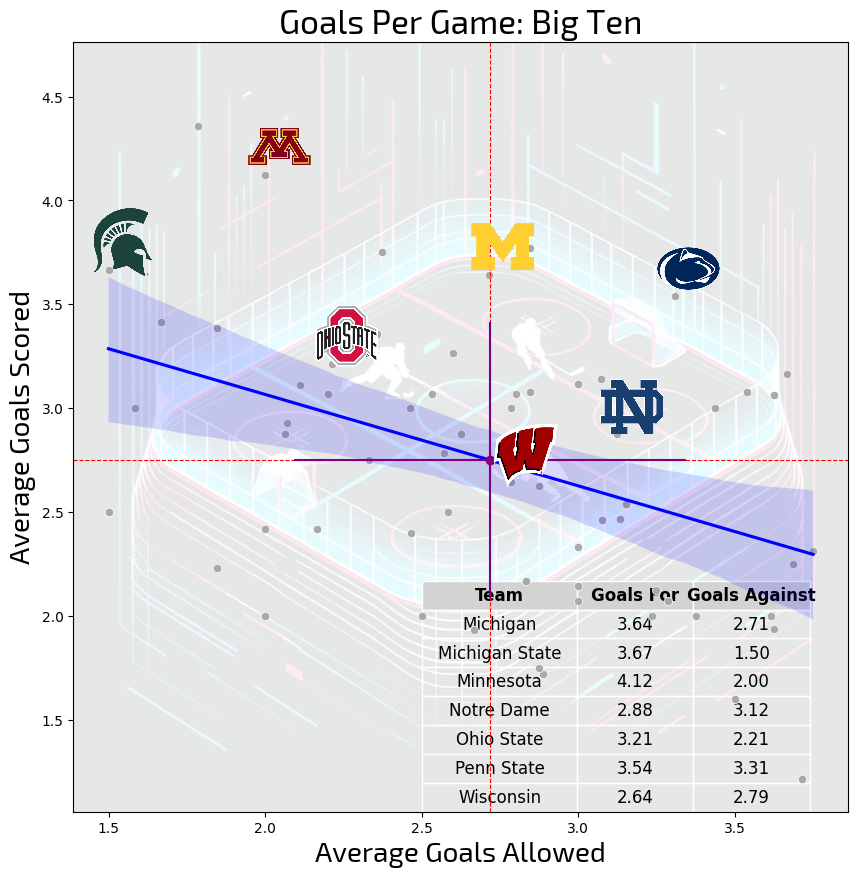

In [517]:
# Call the function
create_avg_goals_plot(group_title, teams_to_plot)

#### Penalty Plot (Scatter)

In [518]:
def create_avg_penalty_plot(group_title, conn, teams_to_plot, show_table=True):
    def add_table_to_plot(ax, avg_penalty_df, teams_to_plot):
        """Adds a table of team penalty stats to the plot."""
        # Create table data
        table_data = [['Team', 'PIM', 'Opp PIM']]
        for team in teams_to_plot:
            team_data = avg_penalty_df[avg_penalty_df['Team'] == team]
            if not team_data.empty:
                table_data.append([
                    team, 
                    f"{team_data['Avg_Penalty_Minutes_For'].values[0]:.1f}",
                    f"{team_data['Avg_Penalty_Minutes_Against'].values[0]:.1f}"
                ])

        # Add table
        table = plt.table(
            cellText=table_data,
            loc='best',
            colWidths=col_widths,  # Assume col_widths is predefined elsewhere
            cellLoc='center',
            bbox=[0.45, 0, 0.5, 0.3]
        )
        
        # Customize the table
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1, 1.5)
        for (row, col), cell in table.get_celld().items():
            if row == 0:  # Header row
                cell.set_text_props(weight='bold')
                cell.set_facecolor('lightgrey')
            else:
                cell.set_facecolor('none')
            cell.set_edgecolor('w')

    # SQL query to calculate the average penalty minutes "for" and "against" each team
    avg_penalty_query = """
    WITH UniqueGames AS (
    SELECT DISTINCT Team, Game_ID, PIM FROM linescore
    )
    SELECT
        a.Team,
        AVG(a.PIM) AS Avg_Penalty_Minutes_For,
        AVG(b.PIM) AS Avg_Penalty_Minutes_Against
    FROM UniqueGames AS a
    JOIN UniqueGames AS b ON a.Game_ID = b.Game_ID AND a.Team != b.Team
    GROUP BY a.Team;
    """
    
    # Execute the query and store the results in a DataFrame
    avg_penalty_df = pd.read_sql(avg_penalty_query, conn)

    # Calculate average and standard deviation for "For" and "Against"
    avg_for = avg_penalty_df['Avg_Penalty_Minutes_For'].mean()
    std_for = avg_penalty_df['Avg_Penalty_Minutes_For'].std()
    avg_against = avg_penalty_df['Avg_Penalty_Minutes_Against'].mean()
    std_against = avg_penalty_df['Avg_Penalty_Minutes_Against'].std()

    # Set figure size
    figure_size = (10, 10)
    fig, ax = plt.subplots(figsize=figure_size)

    # Scatter plot for all teams
    sns.scatterplot(
        data=avg_penalty_df,
        x='Avg_Penalty_Minutes_Against',
        y='Avg_Penalty_Minutes_For',
        color='darkgrey',
        ax=ax
    )

    # Add trend line with standard deviation shading
    sns.regplot(
        data=avg_penalty_df,
        x='Avg_Penalty_Minutes_Against',
        y='Avg_Penalty_Minutes_For',
        scatter=False,
        color='blue',
        ax=ax,
        ci=95,  # Confidence interval for shading (default 95%)
        truncate=False
    )

    # Get axis limits
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # Add average lines and standard deviation markers
    plt.axhline(y=avg_for, color='red', linestyle='--', linewidth=0.8)
    plt.axvline(x=avg_against, color='red', linestyle='--', linewidth=0.8)
    plt.errorbar(avg_against, avg_for, xerr=std_against, yerr=std_for, color='purple', fmt='o')

    # Set the background image
    plt.imshow(bg_img, aspect='auto', extent=[xmin, xmax, ymin, ymax], zorder=0, alpha=alpha_value)

    # Overlay logos for specific teams
    add_logos_to_plot(avg_penalty_df, 'Avg_Penalty_Minutes_Against', 'Avg_Penalty_Minutes_For', logo_mapping, logo_folder, ax, teams_to_plot)

    # Conditionally add the table
    if show_table:
        add_table_to_plot(ax, avg_penalty_df, teams_to_plot)

    # Add title and axis labels
    plt.title(f'Penalty Minutes / Game: {group_title}', fontdict=font_title_param)
    plt.xlabel('Opponent PIMS', fontdict=font_label_param)
    plt.ylabel('Team PIMS', fontdict=font_label_param)

    # Set the tick labels font size and properties
    plt.xticks(fontsize=large_tick_label_size)
    plt.yticks(fontsize=large_tick_label_size)



    # Save the plot
    plot_path = f'{TEMP_FOLDER}{group_title}_penalty_plot.png'
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()


#### Call Function

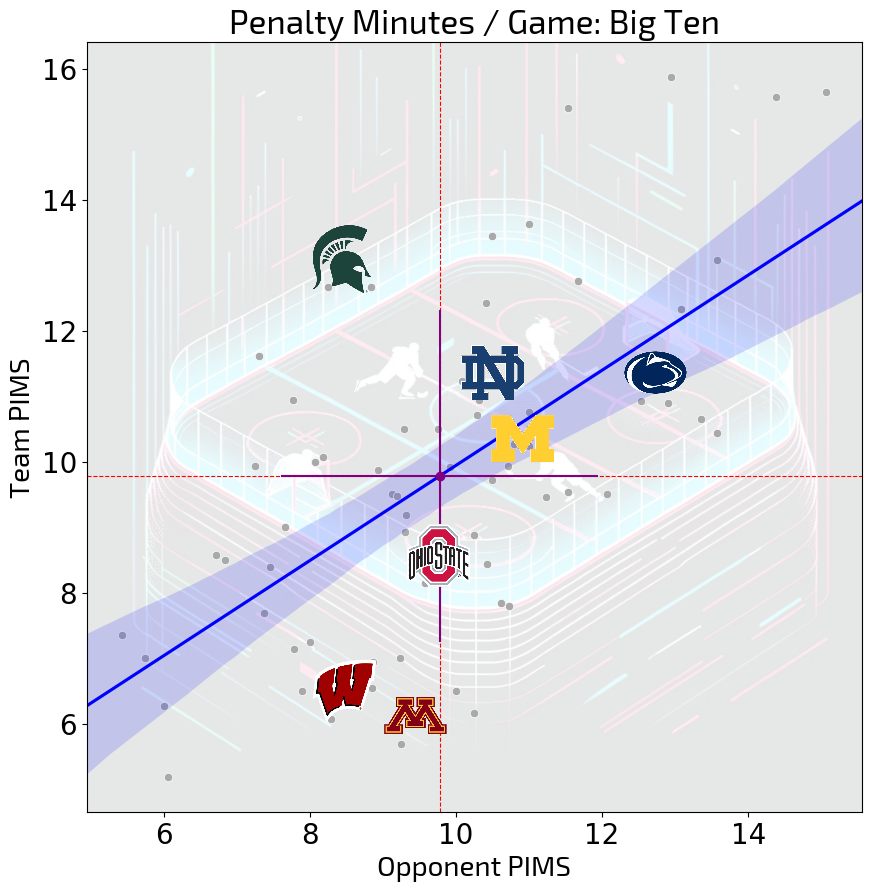

In [519]:
# Create plot with table and standard deviation shading
# create_avg_penalty_plot(group_title, conn, teams_to_plot, show_table=True)

# Create plot without table (standard deviation shading is still displayed)
create_avg_penalty_plot(group_title, conn, teams_to_plot, show_table=False)


#### Penalty Box Occupancy by Game Phase

##### Helper Functions

In [520]:
def calculate_dynamic_figure_size(teams_to_plot, base_figure_size):
    """
    Calculates dynamic figure size based on the number of teams.
    
    Parameters:
    - teams_to_plot (list): List of teams to be plotted.
    - base_figure_size (tuple): The base (width, height) figure size.

    Returns:
    - dynamic_figure_size (tuple): Adjusted (width, height) figure size.
    """
    width, base_height = base_figure_size
    num_teams = len(teams_to_plot)
    if num_teams <= 4:
        return base_figure_size  # Use the base size for small groups
    else:
        additional_height = max(0, (num_teams - 4)) * 1  # 1 inch per extra team
        return (width, base_height + additional_height)


def add_logo_left_margin(ax, team, logo_mapping, logo_folder, zoom=0.15, x_margin=0.15, y_offset=0):
    """
    Adds a team logo to the left margin of the plot, replacing text labels.

    Parameters:
    - ax: The matplotlib axis object where the logo will be added.
    - team (str): Team name.
    - logo_mapping (dict): Dictionary mapping team names to logo file names.
    - logo_folder (str): Path to the folder containing logo images.
    - zoom (float): Scaling factor for the logo.
    - x_margin (float): Proportion of the figure width reserved for the margin.
    - y_offset (float): Vertical offset for fine-tuning the position (in axes fraction).
    """
    logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
    if logo_path:
        try:
            logo_img = plt.imread(logo_path)
            # Determine vertical center in axes coordinates
            y_mid = 0.5 + y_offset
            # Position in the left margin (relative to axes)
            x_pos = -x_margin  # Left of the plot area
            imagebox = OffsetImage(logo_img, zoom=zoom)
            ab = AnnotationBbox(
                imagebox,
                (x_pos, y_mid),  # Apply x-margin and vertical centering
                frameon=False,
                xycoords='axes fraction',
                boxcoords='axes fraction',
                pad=0
            )
            ax.add_artist(ab)
        except Exception as e:
            print(f"Error adding logo for {team}: {e}")


def calculate_logo_zoom(num_teams):
    """
    Dynamically calculates the zoom factor for team logos based on the number of teams.
    
    Parameters:
    - num_teams (int): The number of teams in the list.
    
    Returns:
    - zoom (float): The calculated zoom factor.
    """
    # Define the known data points for team count and zoom
    team_counts = [4, 7, 11]  # Known team counts
    zoom_values = [0.45, 0.3, 0.25]  # Corresponding zoom levels
    
    if num_teams <= team_counts[0]:
        return zoom_values[0]  # Use maximum zoom for small groups
    elif num_teams >= team_counts[-1]:
        return zoom_values[-1]  # Use minimum zoom for large groups
    else:
        # Linearly interpolate between the known points
        slope = (zoom_values[2] - zoom_values[1]) / (team_counts[2] - team_counts[1])
        return zoom_values[1] + slope * (num_teams - team_counts[1])

def calculate_x_margin(zoom, base_zoom=0.3, base_margin=0.075):
    """
    Dynamically calculates the x_margin value based on the zoom factor.
    
    Parameters:
    - zoom (float): The zoom factor for the logo.
    - base_zoom (float): The baseline zoom factor (default is 0.3).
    - base_margin (float): The baseline x_margin for the baseline zoom factor (default is 0.075).
    
    Returns:
    - x_margin (float): The calculated x_margin value.
    """
    # Scale x_margin proportionally to the zoom factor
    return base_margin * (zoom / base_zoom)



In [521]:
def extract_penalty_summary(conn):
    """
    Extracts and preprocesses the penalty summary data from the database.
    """
    query = """
    WITH UniquePenalties AS (
        SELECT DISTINCT * FROM penalty_summary
    )
    SELECT * FROM UniquePenalties;
    """
    penalty_df = pd.read_sql(query, conn)
    penalty_df['Pen_Length'] = penalty_df['Pen_Length'].astype('int')
    return penalty_df


def convert_to_continuous_time(row):
    """
    Converts period-based time to a continuous format (0-65 minutes).
    """
    period_offsets = {'1st Period': 0, '2nd Period': 20, '3rd Period': 40, 'OT': 60}
    minutes, seconds = map(int, row['Time'].split(':'))
    offset = period_offsets.get(row['Period'], 0)
    return offset + minutes + seconds / 60.0


def add_period_shading(ax):
    """
    Adds shading for periods to the plot background.
    """
    ax.axvspan(0, 20, facecolor='lightgrey', alpha=0.5, zorder=0)
    ax.axvspan(20, 40, facecolor='yellow', alpha=0.75, zorder=0)
    ax.axvspan(40, 60, facecolor='lightgrey', alpha=0.5, zorder=0)
    ax.axvspan(60, 65, facecolor='yellow', alpha=0.75, zorder=0)

def plot_team_penalties(ax, team, penalty_data, color_mapping, logo_mapping, logo_folder, bins=65):
    """
    Plots penalty box occupancy over time for a specific team and its opponents.
    """
    penalty_data['Start_Time'] = penalty_data.apply(convert_to_continuous_time, axis=1)
    penalty_data['End_Time'] = penalty_data['Start_Time'] + penalty_data['Pen_Length']
    penalty_data = penalty_data[penalty_data['Pen_Length'].isin([2, 5])]

    # Filter data for team and opponents
    team_data = penalty_data[penalty_data['Team'] == team]
    opponent_data = penalty_data[penalty_data['Game_ID'].isin(team_data['Game_ID'].unique()) & (penalty_data['Team'] != team)]

    time_points = np.linspace(0, 65, 65 * 60)
    team_penalty_count = np.zeros_like(time_points)
    opponent_penalty_count = np.zeros_like(time_points)

    # Populate counts
    for _, row in team_data.iterrows():
        start_idx = np.searchsorted(time_points, row['Start_Time'])
        end_idx = np.searchsorted(time_points, row['End_Time'])
        team_penalty_count[start_idx:end_idx] += 1

    for _, row in opponent_data.iterrows():
        start_idx = np.searchsorted(time_points, row['Start_Time'])
        end_idx = np.searchsorted(time_points, row['End_Time'])
        opponent_penalty_count[start_idx:end_idx] += 1

    color = color_mapping.get(team, ['#000000'])[0]  # Default to black if team not found
    ax.hist(time_points, bins=bins, weights=team_penalty_count, color=color, alpha=0.9, edgecolor='black', label=f'{team} Penalties')
    ax.hist(time_points, bins=bins, weights=opponent_penalty_count, color='grey', alpha=0.5, edgecolor='black', label='Opponent Penalties')

    # Set x-axis ticks and labels
    ax.set_xticks([10, 30, 50, 62.5])
    ax.set_xticklabels(['1st Period', '2nd Period', '3rd Period', 'OT'], **font_tick_param)

    
    # Set labels and title
    ax.set_ylabel(team, **font_label_param)
    ax.grid(False)
    add_period_shading(ax)

    # Remove Y-axis ticks
    ax.set_yticks([])


def create_penalty_summary_plot(region_name, conn, teams_to_plot, color_mapping, logo_mapping, logo_folder, base_figure_size, use_logos_as_y_labels=False):
    """
    Creates a summary plot for penalty box occupancy over game time for a set of teams.

    Parameters:
    - region_name (str): Title of the region or group being plotted.
    - conn: Database connection object.
    - teams_to_plot (list): List of teams to be plotted.
    - color_mapping (dict): Dictionary of team colors.
    - logo_mapping (dict): Dictionary of team logos.
    - logo_folder (str): Path to the folder containing logos.
    - base_figure_size (tuple): Base figure size (width, height).
    - use_logos_as_y_labels (bool): Whether to use team logos instead of text for y-axis labels.
    """
    # Dynamically calculate the figure size
    figure_size = calculate_dynamic_figure_size(teams_to_plot, base_figure_size)

    # Extract penalty data
    penalty_data = extract_penalty_summary(conn)

    # Set up the figure with dynamic size
    fig, axes = plt.subplots(len(teams_to_plot), 1, figsize=figure_size, sharex=True)
    if len(teams_to_plot) == 1:
        axes = [axes]  # Ensure axes is iterable

    # Adjust margin for logos
    left_margin = 0.25 if use_logos_as_y_labels else 0.1  # Adjust margin dynamically
    for ax in axes:
        pos = ax.get_position()
        ax.set_position([pos.x0 + left_margin, pos.y0, pos.width - left_margin, pos.height])  # Shift axes


    # Plot each team's penalties
    for ax, team in zip(axes, teams_to_plot):
        penalty_data_team = penalty_data[penalty_data['Team'] == team]
        if penalty_data_team.empty:
            continue  # Skip if no data for the team

        # Plot team penalties
        plot_team_penalties(ax, team, penalty_data, color_mapping, logo_mapping, logo_folder)
        # Dynamically calculate the zoom factor based on the number of teams
        zoom_factor = calculate_logo_zoom(len(teams_to_plot))
        # Dynamically calculate the x_margin based on the zoom factor
        x_margin = calculate_x_margin(zoom_factor)

        # Use team logo or name for y-axis label
        if use_logos_as_y_labels:
            # Clear the default y-axis label
            ax.set_ylabel('')
            # Add the team logo in place of the label
            add_logo_left_margin(
                ax=ax,
                team=team,
                logo_mapping=logo_mapping,
                logo_folder=logo_folder,
                zoom=zoom_factor,  # Adjustable zoom
                x_margin=x_margin,  # Adjust based on left margin
                y_offset=-0.05  # Adjust to control vertical placement
            )
        else:
            # Use text for y-axis label
            ax.set_ylabel(team, **font_label_param)

            # Remove subplot borders
        for spine in ax.spines.values():
            spine.set_visible(False)  # Hides the border for all spines

    # Adjust layout for spacing between subplots
    plt.subplots_adjust(hspace=0.05)  # Fine-tune vertical spacing
    
    # Apply shared font parameters for the title
    fig.suptitle(f'Penalty Box Occupancy Over Game Time: {region_name}', **font_title_param)


    # Add x-axis label to the last subplot
    axes[-1].set_xlabel('Game Time (Minutes)', **font_label_param)

    # Adjust layout
    plt.tight_layout()
    plt.show()



###### Test Dictionaries

In [522]:
# Create four team dictionary for testing
# teams_to_plot = ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame']

# 15 team dictionary for testing
# teams_to_plot = ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin', 'Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 'St Cloud State']




###### End

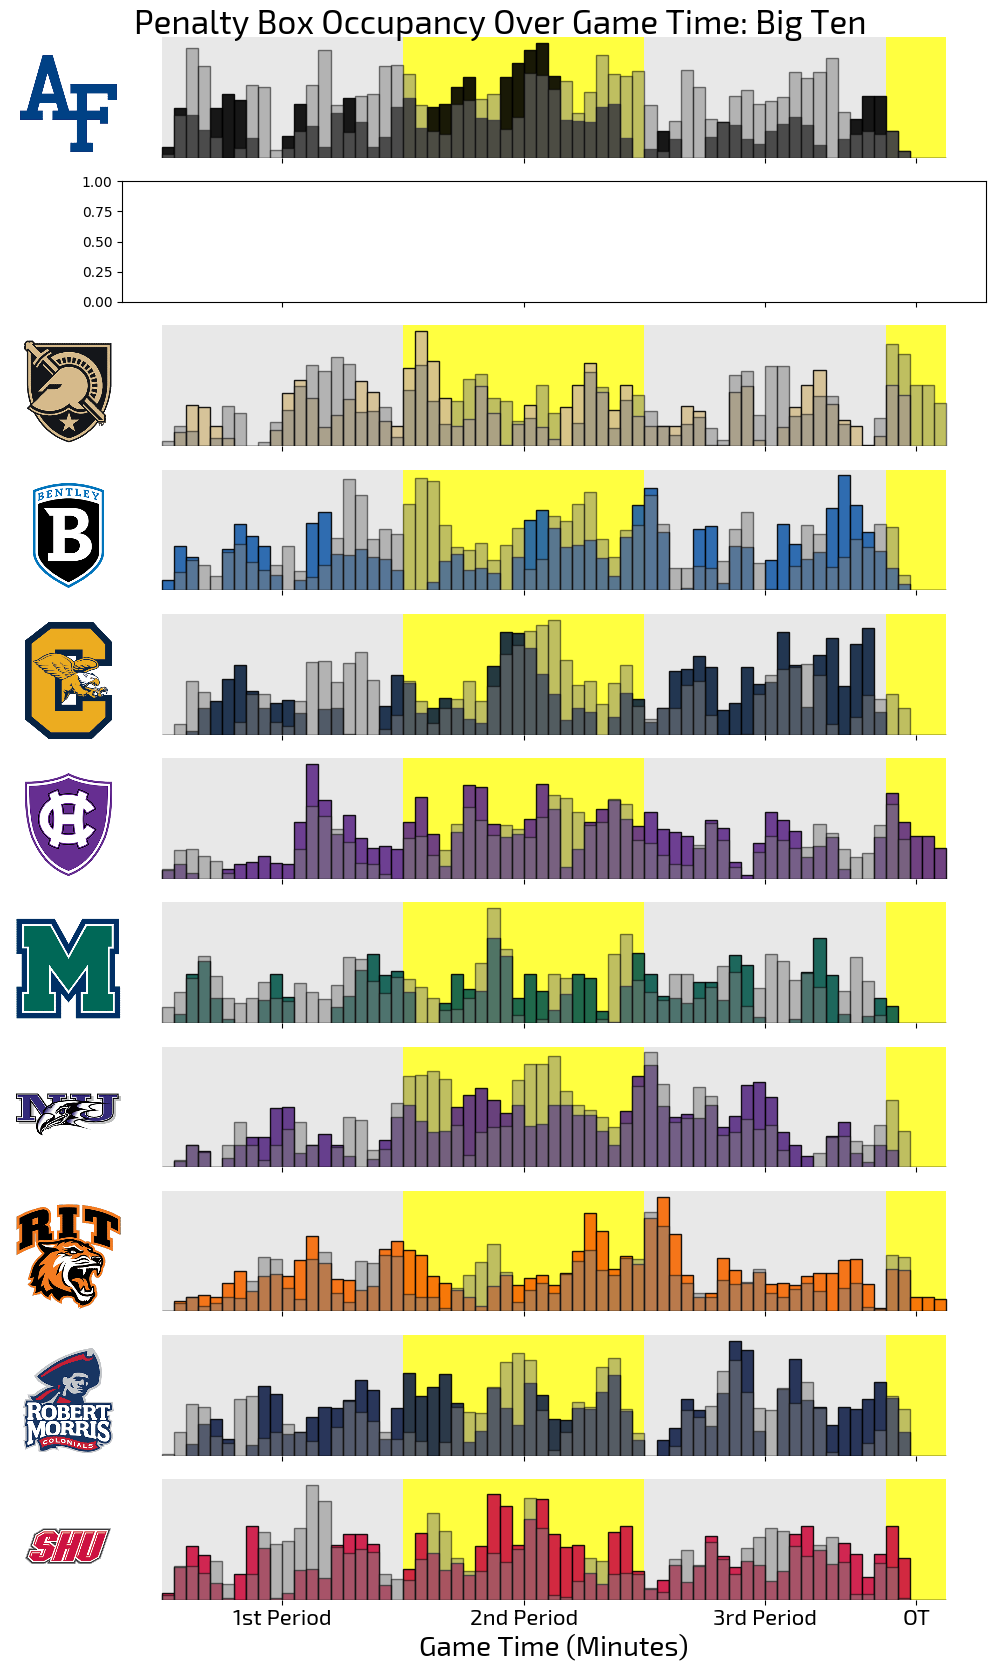

In [523]:
region_name = "Hockey East"
region_name = "Big Ten"
# region_name = "Atlantic"

# teams_to_plot = conference_teams_mens['Hockey East']
teams_to_plot = conference_teams_mens['Big Ten']
teams_to_plot = conference_teams_mens['Atlantic']


# Call the plot function with dynamic sizing
create_penalty_summary_plot(
    region_name=region_name,
    conn=conn,  # Active database connection
    teams_to_plot=teams_to_plot,
    color_mapping=color_mapping,
    logo_mapping=logo_mapping,
    logo_folder=logo_folder,  # Path to logo files
    base_figure_size=figure_size,
    use_logos_as_y_labels=True  # Use logos instead of text for y-axis labels  # Reference global figure size
)


#### Special Teams Scatter Plot

#### Line By Line Production